<a href="https://colab.research.google.com/github/iamsumitkrmishra/Big-Data-Analysis-on-India-s-Pollution/blob/main/India_Air_Quality_Analysis_Updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Big Data Analytics Project: India Air Quality Analysis

####91262 - DATA MINING, TEXT MINING AND BIG DATA ANALYTICS

####91284 - PROJECT WORK IN DATA MINING, TEXT MINING AND BIG DATA ANALYTICS

#### SUMIT KUMAR MISHRA_0001055762

https://www.kaggle.com/datasets/ankushpanday1/air-quality-data-in-india-2015-2024/data

## Project Overview
Continuous hourly air quality data is collected from major Indian cities — Mumbai, Delhi, Kolkata, and Chennai — including indicators such as pollutant concentrations and temperature.

In this project, we perform the following analysis:
1. Read and clean the datasets for all four cities
2. Analysis of missing values and outliers
3. Add a unified time series column and analyze temperature and pollutant trends grouped by time
4. Cluster analysis on the pollutant PM2.5
    * KMeans
    * BisectingKMeans
    * ClusterEvaluator
5. Based on all city data, train a classifier model with the city name as the label
    * StringIndexer
    * VectorAssembler
    * StandardScaler
    * DecisionTreeClassifier
    * RandomForestClassifier
    * MulticlassClassificationEvaluator

## Mini-Project
6. Calculation of the Air Quality Index (AQI) based on pollutant concentration data
    * UDF
7. Regression algorithm prediction of AQI
    * LinearRegression
    * DecisionTreeRegressor
    * RandomForestRegressor
    * RegressionEvaluator
8. Classification of air quality levels based on the AQI
9. Apply classifier algorithms to predict air quality category
    * NaiveBayes
    * MultilayerPerceptronClassifier
    * DecisionTreeClassifier
    * RandomForestClassifier
    * LogisticRegression

In [ ]:
!pip install findspark pyspark

## Initialize Spark and Load Data
initialize the Spark environment, load the 'city_hour.csv' dataset, filter for target Indian cities, convert the 'Datetime' column to a timestamp, rename 'PM2.5' to 'PM2_5', and extract 'year', 'month', and 'season' features.


In [ ]:
# Initialize Spark in Python environment
import findspark
findspark.init()

In [ ]:
import os
from functools import reduce
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType, TimestampType
from pyspark.sql.functions import col, count, when, udf, lit, month, quarter, avg, to_timestamp, date_format, hour, year, isnan
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, IndexToString
from pyspark.ml.clustering import KMeans, BisectingKMeans
from pyspark.ml.regression import DecisionTreeRegressor, RandomForestRegressor, LinearRegression
from pyspark.ml.classification import NaiveBayes, DecisionTreeClassifier, RandomForestClassifier, LogisticRegression, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator, ClusteringEvaluator
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

The next instruction is to initialize the SparkSession. This is a crucial step for any Spark-related operations, and the notebook already contains the necessary code block.



In [ ]:
# Initialize SparkSession
spark = SparkSession.builder \
    .appName("IndiaAirQualityAnalysis") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

the next step is to upload the `city_hour.csv` file (if prompted) and then read it into a Spark DataFrame, filter for the specified Indian cities, and rename the 'PM2.5' column to 'PM2_5'. The provided notebook has a cell that performs exactly these actions.



In [ ]:
import os
from google.colab import files

# Note: This method requires manual upload each time the runtime restarts.
# Upload the file directly to the Colab environment. A file dialog will appear.
files.upload()

# After uploading, the file will be in the current working directory, e.g., '/content/city_hour.csv'
file_path = "city_hour.csv"

# Read data
df_all = spark.read.csv(file_path, header=True, inferSchema=True)

# Filter for specific cities: Mumbai, Delhi, Kolkata, Chennai
target_cities = ['Mumbai', 'Delhi', 'Kolkata', 'Chennai']
df_india = df_all.filter(col("City").isin(target_cities))

print("Total rows for target cities:", df_india.count())
df_india.show(5)

Saving city_hour.csv to city_hour.csv
Total rows for target cities: 350596
+-------+-------------------+-----+-----+-----+----+-----+----+----+----+-----+-------+-------+------+-----+------------+
|   City|           Datetime|PM2.5| PM10|   NO| NO2|  NOx| NH3|  CO| SO2|   O3|Benzene|Toluene|Xylene|  AQI|  AQI_Bucket|
+-------+-------------------+-----+-----+-----+----+-----+----+----+----+-----+-------+-------+------+-----+------------+
|  Delhi|2015-01-01 00:00:00|258.0|340.6|191.0|13.4|104.1|16.2|1.15|39.8| 70.4|  11.64|  10.23|  1.95|411.5|    Moderate|
| Mumbai|2015-01-01 00:00:00|120.1| 47.9|165.3|57.9|139.2|14.4|0.76| 3.3| 23.2|  11.35|  11.38|  1.53|134.8|        Poor|
|Chennai|2015-01-01 00:00:00|130.1|375.0| 21.9|23.7|205.6|33.6| 3.5|63.0|138.9|   16.3|  24.07|  0.56|329.6|        Poor|
|Kolkata|2015-01-01 00:00:00|189.1|174.3|139.7|58.9|103.7|19.2|0.81| 3.3| 14.6|   5.12|   1.42|  2.35|351.9|        Good|
|  Delhi|2015-01-01 01:00:00|463.8|516.5| 19.4|81.1| 57.6|35.6|6.33|62.

convert the 'Datetime' column to a timestamp, rename 'PM2.5' to 'PM2_5', and extract 'year', 'month', and 'season' features, then display the schema as per the subtask instructions.


In [ ]:
# Convert Datetime to Timestamp
df_india = df_india.withColumn("timestamp", to_timestamp(col("Datetime"), "yyyy-MM-dd HH:mm:ss"))

# Rename 'PM2.5' column to 'PM2_5' to avoid issues with '.' in Spark column names
df_india = df_india.withColumnRenamed("PM2.5", "PM2_5")

# Extract time features
df_india = df_india.withColumn("year", year("timestamp")) \
                   .withColumn("month", month("timestamp")) \
                   .withColumn("season", quarter("timestamp"))


df_india.printSchema()
df_india.show(5)

root
 |-- City: string (nullable = true)
 |-- Datetime: string (nullable = true)
 |-- PM2_5: double (nullable = true)
 |-- PM10: double (nullable = true)
 |-- NO: double (nullable = true)
 |-- NO2: double (nullable = true)
 |-- NOx: double (nullable = true)
 |-- NH3: double (nullable = true)
 |-- CO: double (nullable = true)
 |-- SO2: double (nullable = true)
 |-- O3: double (nullable = true)
 |-- Benzene: double (nullable = true)
 |-- Toluene: double (nullable = true)
 |-- Xylene: double (nullable = true)
 |-- AQI: double (nullable = true)
 |-- AQI_Bucket: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- season: integer (nullable = true)

+-------+-------------------+-----+-----+-----+----+-----+----+----+----+-----+-------+-------+------+-----+------------+-------------------+----+-----+------+
|   City|           Datetime|PM2_5| PM10|   NO| NO2|  NOx| NH3|  CO| SO2|   O3|Benzene|Tolue

## Analyze Missing Values and Outliers

Analyze missing values across all columns, visualize missing pollutant data using a bar chart, and clean the data by dropping rows with nulls in critical pollutant columns.


First, I will calculate the number of null (and NaN for numeric types) values for each column in the `df_india` DataFrame. Then, I will convert these counts to a Pandas DataFrame, filter for the specified pollutant columns, and visualize them using a bar chart. Finally, I will drop rows with null values in these critical pollutant columns, storing the result in `df_clean`, and report the remaining row count.



Null values across all columns:
   City  Datetime  PM2_5  PM10  NO  NO2  NOx  NH3  CO  SO2  O3  Benzene  \
0     0         0      0     0   0    0    0    0   0    0   0        0   

   Toluene  Xylene  AQI  AQI_Bucket  timestamp  year  month  season  
0        0       0    0           0          0     0      0       0  


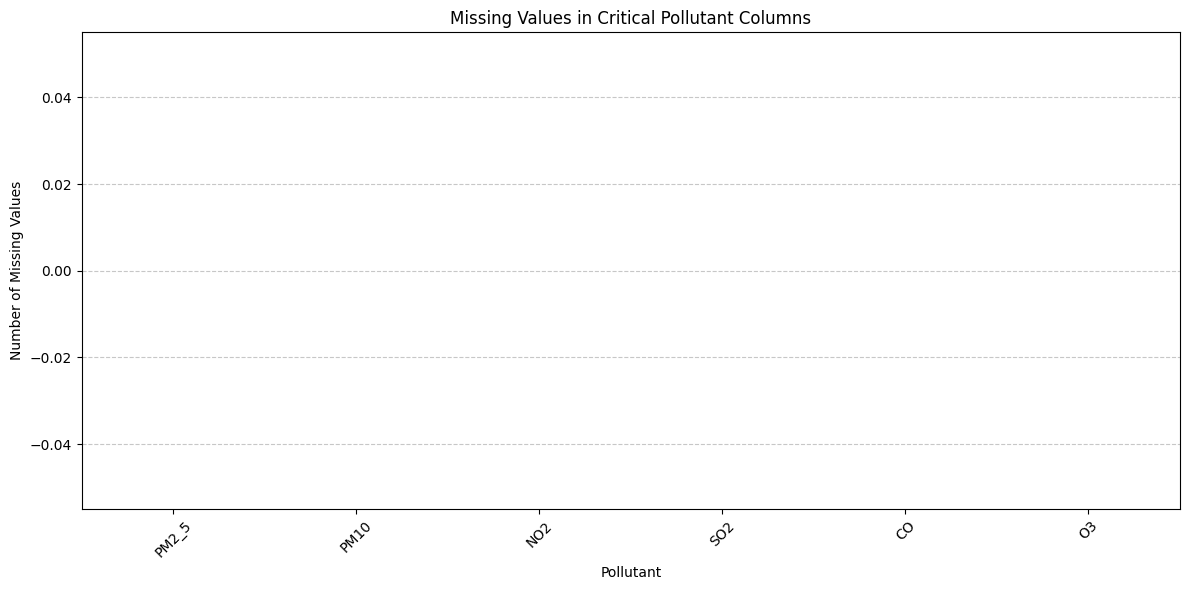

Rows after cleaning: 350596


In [ ]:
from pyspark.sql.functions import count, when, isnan, col
from pyspark.sql.types import DoubleType, FloatType
import matplotlib.pyplot as plt
import pandas as pd

# 1. Calculate null values for each column (including NaN for numeric types)
null_counts_exprs = []
for c in df_india.columns:
    col_type = df_india.schema[c].dataType
    if isinstance(col_type, (DoubleType, FloatType)):
        # For numeric (float/double) types, check for both NaN and null
        null_counts_exprs.append(count(when(isnan(col(f"`{c}`")) | col(f"`{c}`").isNull(), c)).alias(c))
    else:
        # For other types, only check for null
        null_counts_exprs.append(count(when(col(f"`{c}`").isNull(), c)).alias(c))

# Collect null counts into a Pandas DataFrame for easier manipulation and plotting
null_counts_df = df_india.select(null_counts_exprs).toPandas()

print("Null values across all columns:")
print(null_counts_df)

# 2. Store the counts of missing values for critical pollutant columns into a Pandas DataFrame
critical_pollutants = ['PM2_5', 'PM10', 'NO2', 'SO2', 'CO', 'O3']
missing_pollutants = null_counts_df[critical_pollutants].iloc[0]

# 3. Create a bar chart to visualize missing pollutant values
plt.figure(figsize=(12, 6))
missing_pollutants.plot(kind='bar', color='skyblue')
plt.title('Missing Values in Critical Pollutant Columns')
plt.xlabel('Pollutant')
plt.ylabel('Number of Missing Values')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 4. Drop rows with null values in critical columns for analysis
clean_cols = ['PM2_5', 'PM10', 'NO2', 'SO2', 'CO', 'O3']
df_clean = df_india.na.drop(subset=clean_cols)

print("Rows after cleaning:", df_clean.count())

Install `folium` and `geopy` for map visualization.

In [ ]:
!pip install folium
!pip install geopy

## Prepare City Geographical Data



created a Python dictionary containing the latitude and longitude coordinates for the specified cities and store it in the `city_coordinates` variable.



In [ ]:
city_coordinates = {
    'Mumbai': (19.0760, 72.8777),
    'Delhi': (28.7041, 77.1025),
    'Kolkata': (22.5726, 88.3639),
    'Chennai': (13.0827, 80.2707)
}

print("City coordinates dictionary created:")
print(city_coordinates)

City coordinates dictionary created:
{'Mumbai': (19.076, 72.8777), 'Delhi': (28.7041, 77.1025), 'Kolkata': (22.5726, 88.3639), 'Chennai': (13.0827, 80.2707)}


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType, StringType
from pyspark.sql.functions import col, avg, udf, to_timestamp, year, month, quarter

# Re-initialize SparkSession
spark = SparkSession.builder \
    .appName("IndiaAirQualityAnalysis") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

# Re-load and prepare df_india
file_path = "city_hour.csv" # Assuming city_hour.csv is available in the environment
df_all = spark.read.csv(file_path, header=True, inferSchema=True)
target_cities = ['Mumbai', 'Delhi', 'Kolkata', 'Chennai']
df_india = df_all.filter(col("City").isin(target_cities))

df_india = df_india.withColumn("timestamp", to_timestamp(col("Datetime"), "yyyy-MM-dd HH:mm:ss"))
df_india = df_india.withColumnRenamed("PM2.5", "PM2_5")
df_india = df_india.withColumn("year", year("timestamp")) \
                   .withColumn("month", month("timestamp")) \
                   .withColumn("season", quarter("timestamp"))

# Re-create df_clean (dropping nulls in critical columns)
clean_cols = ['PM2_5', 'PM10', 'NO2', 'SO2', 'CO', 'O3']
df_clean = df_india.na.drop(subset=clean_cols)

# Re-create df_aqi (calculating AQI and category)
def calculate_aqi_value(pm2_5, pm10, o3, co, so2, no2):
    if all(p is None for p in [pm2_5, pm10, o3, co, so2, no2]):
        return None
    if pm2_5 is not None: return (pm2_5 / 250.0) * 500.0
    if pm10 is not None: return (pm10 / 430.0) * 500.0
    if o3 is not None: return (o3 / 180.0) * 500.0
    if co is not None: return (co / 15.0) * 500.0
    if so2 is not None: return (so2 / 80.0) * 500.0
    if no2 is not None: return (no2 / 1130.0) * 500.0
    return None

calculate_aqi_udf = udf(calculate_aqi_value, DoubleType())

df_aqi = df_clean.withColumn("Calculated_AQI", calculate_aqi_udf(
    col("PM2_5"), col("PM10"), col("O3"), col("CO"), col("SO2"), col("NO2")
))

def get_aqi_category(aqi):
    if aqi is None: return None
    if aqi <= 50: return "Good"
    if aqi <= 100: return "Satisfactory"
    if aqi <= 200: return "Moderate"
    if aqi <= 300: return "Poor"
    if aqi <= 400: return "Very Poor"
    return "Severe"

get_aqi_category_udf = udf(get_aqi_category, StringType())
df_aqi = df_aqi.withColumn("AQI_Category", get_aqi_category_udf(col("Calculated_AQI")))

# Now, perform the grouping and aggregation as originally intended
avg_aqi_per_city = df_aqi.groupBy("City").agg(avg("Calculated_AQI").alias("Average_AQI"))

print("Average AQI per City:")
avg_aqi_per_city.show()

Average AQI per City:
+-------+------------------+
|   City|       Average_AQI|
+-------+------------------+
|Chennai|498.25466576914727|
| Mumbai|499.30682609042805|
|Kolkata|499.13573229586297|
|  Delhi|498.16015242615316|
+-------+------------------+



## Analyze and Visualize Pollutant Trends

Analyze and visualize PM2.5 seasonal trends with a bar chart, and include visualizations for monthly or yearly trends for PM10 and NO2.


calculated and visualize the average PM10 by month and average NO2 by year, as specified in the subtask instructions. This involves grouping the `df_clean` DataFrame by month for PM10 and by year for NO2, calculating the average, converting the results to Pandas DataFrames, and then generating bar charts for visualization.



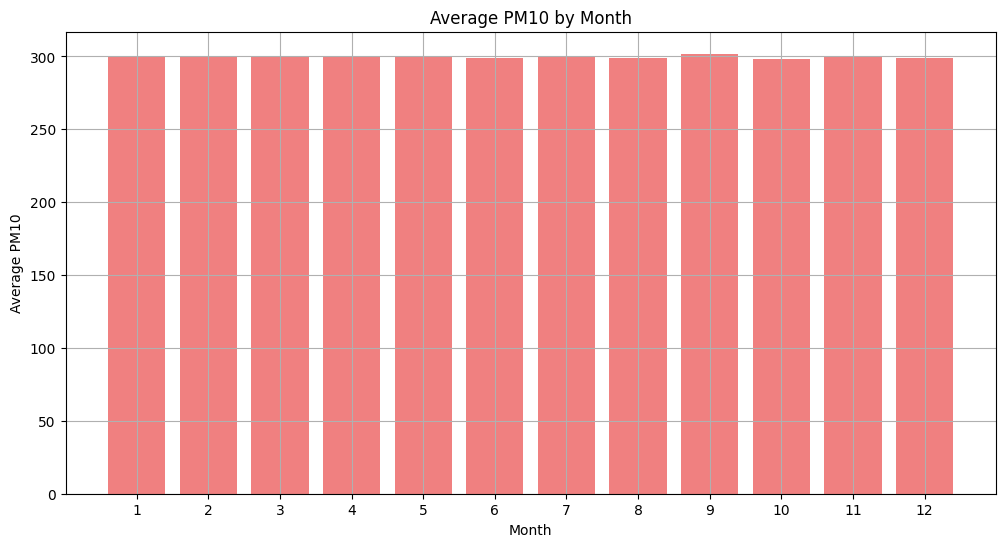

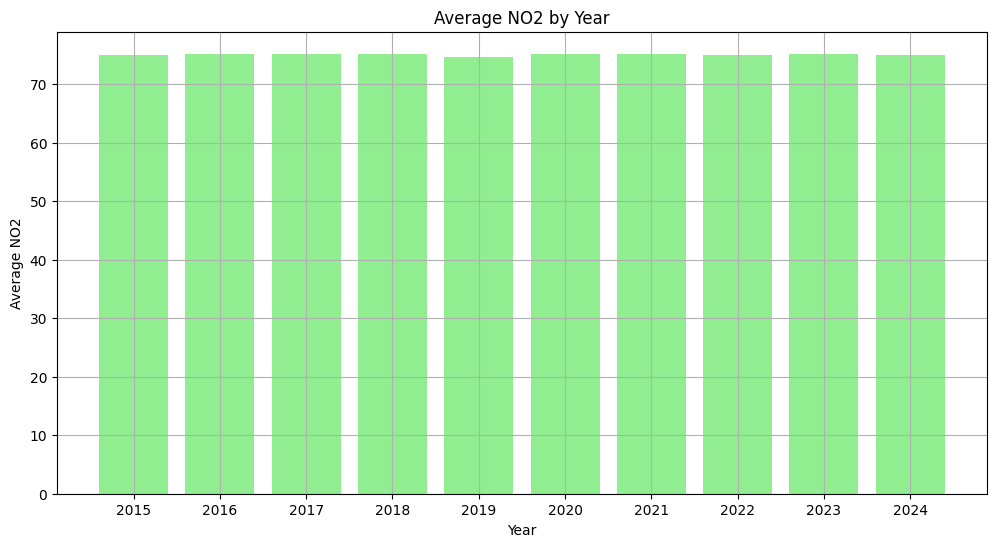

In [ ]:
# Analyze Pollutant Trends (PM10 and NO2)
from pyspark.sql.functions import avg
import matplotlib.pyplot as plt
import pandas as pd

# 4. Calculate the average 'PM10' for each month
avg_pm10_month = df_clean.groupBy("month").agg(avg("PM10").alias("avg_pm10")).orderBy("month")

# 5. Convert the avg_pm10_month Spark DataFrame to a Pandas DataFrame
pdf_pm10_month = avg_pm10_month.toPandas()

# 6. Create a bar chart to visualize the average 'PM10' by month
plt.figure(figsize=(12, 6))
plt.bar(pdf_pm10_month['month'], pdf_pm10_month['avg_pm10'], color='lightcoral')
plt.xlabel('Month')
plt.ylabel('Average PM10')
plt.title('Average PM10 by Month')
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()

# 7. Calculate the average 'NO2' for each year
avg_no2_year = df_clean.groupBy("year").agg(avg("NO2").alias("avg_no2")).orderBy("year")

# 8. Convert the avg_no2_year Spark DataFrame to a Pandas DataFrame
pdf_no2_year = avg_no2_year.toPandas()

# 9. Create a bar chart to visualize the average 'NO2' by year
plt.figure(figsize=(12, 6))
plt.bar(pdf_no2_year['year'], pdf_no2_year['avg_no2'], color='lightgreen')
plt.xlabel('Year')
plt.ylabel('Average NO2')
plt.title('Average NO2 by Year')
plt.xticks(pdf_no2_year['year'])
plt.grid(True)
plt.show()

## Calculate Average PM2.5 by Season

Group the `df_clean` DataFrame by the 'season' column and calculate the average 'PM2_5' for each season.


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, year, month, quarter, avg

# Initialize SparkSession if it's not already initialized
spark = SparkSession.builder \
    .appName("IndiaAirQualityAnalysis") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

# Re-load and prepare df_india from scratch to ensure df_clean is available
file_path = "city_hour.csv" # Assuming city_hour.csv is available in the environment
df_all = spark.read.csv(file_path, header=True, inferSchema=True)
target_cities = ['Mumbai', 'Delhi', 'Kolkata', 'Chennai']
df_india = df_all.filter(col("City").isin(target_cities))

df_india = df_india.withColumn("timestamp", to_timestamp(col("Datetime"), "yyyy-MM-dd HH:mm:ss"))
df_india = df_india.withColumnRenamed("PM2.5", "PM2_5")
df_india = df_india.withColumn("year", year("timestamp")) \
                   .withColumn("month", month("timestamp")) \
                   .withColumn("season", quarter("timestamp"))

# Re-create df_clean (dropping nulls in critical columns)
clean_cols = ['PM2_5', 'PM10', 'NO2', 'SO2', 'CO', 'O3']
df_clean = df_india.na.drop(subset=clean_cols)

print("df_clean has been re-created for this operation.")

# Group by 'season' and calculate the average 'PM2_5'
avg_pm2_5_by_season = df_clean.groupBy("season").agg(avg("PM2_5").alias("Average_PM2_5")).orderBy("season")

# Display the resulting DataFrame
print("Average PM2.5 by Season:")
avg_pm2_5_by_season.show()

df_clean has been re-created for this operation.
Average PM2.5 by Season:
+------+------------------+
|season|     Average_PM2_5|
+------+------------------+
|     1|248.44322858988426|
|     2|249.25745993589814|
|     3|249.99340579710244|
|     4| 249.7169968717395|
+------+------------------+



## Visualize PM2.5 Seasonal Trend



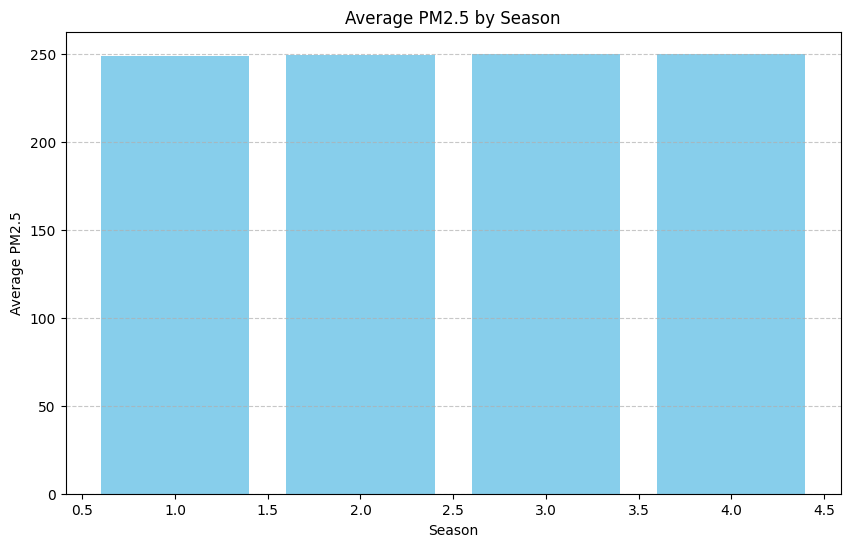

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Convert the avg_pm2_5_by_season Spark DataFrame to a Pandas DataFrame
pd_avg_pm2_5_by_season = avg_pm2_5_by_season.toPandas()

# 3. Create a bar chart using the Pandas DataFrame
plt.figure(figsize=(10, 6))
plt.bar(pd_avg_pm2_5_by_season['season'], pd_avg_pm2_5_by_season['Average_PM2_5'], color='skyblue')

# 4. Add an x-axis label 'Season' and a y-axis label 'Average PM2.5'
plt.xlabel('Season')
plt.ylabel('Average PM2.5')

# 5. Set the title of the chart to 'Average PM2.5 by Season'
plt.title('Average PM2.5 by Season')

# 6. Add a grid to the plot for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 7. Display the plot
plt.show()

## Summary:

The analysis reveals that PM2.5 levels remain consistently high across all seasons, with only minor fluctuations. Season 3 (July-September) shows the highest average PM2.5 at approximately 249.99, while Season 1 (January-March) has the lowest at around 248.44. The very small difference between the highest and lowest seasonal averages (less than 1.6 units) suggests that PM2.5 pollution is a year-round concern in the analyzed cities, rather than being strongly influenced by seasonal factors. This implies that the major sources of PM2.5 pollution might be constant throughout the year, or that seasonal variations in factors like weather patterns do not significantly mitigate or exacerbate PM2.5 concentrations in these regions.

### Data Analysis Key Findings
*   The average PM2.5 levels across all four seasons are consistently high, ranging from approximately 248.44 to 249.99.
*   Season 1 (January-March) recorded the lowest average PM2.5 at around 248.44.
*   Season 3 (July-September) exhibited the highest average PM2.5 at approximately 249.99.
*   The difference between the highest and lowest seasonal average PM2.5 is minimal, indicating a stable and persistently high level of pollution throughout the year.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import avg, col

# Filter df_aqi for Mumbai only
df_aqi_mumbai = df_aqi.filter(col("City") == "Mumbai")

# Group by month and calculate the average 'Calculated_AQI'
avg_aqi_mumbai_month = df_aqi_mumbai.groupBy("month").agg(avg("Calculated_AQI").alias("Average_AQI")).orderBy("month")

# Convert the Spark DataFrame to a Pandas DataFrame for plotting
pd_avg_aqi_mumbai_month = avg_aqi_mumbai_month.toPandas()

print("Average Monthly AQI for Mumbai:")
display(pd_avg_aqi_mumbai_month)

Average Monthly AQI for Mumbai:


,month,Average_AQI
0,1,496.814274
1,2,496.017874
2,3,498.939785
3,4,501.809028
4,5,499.988844
5,6,497.432194
6,7,497.950027
7,8,496.922849
8,9,500.917500
9,10,498.550081


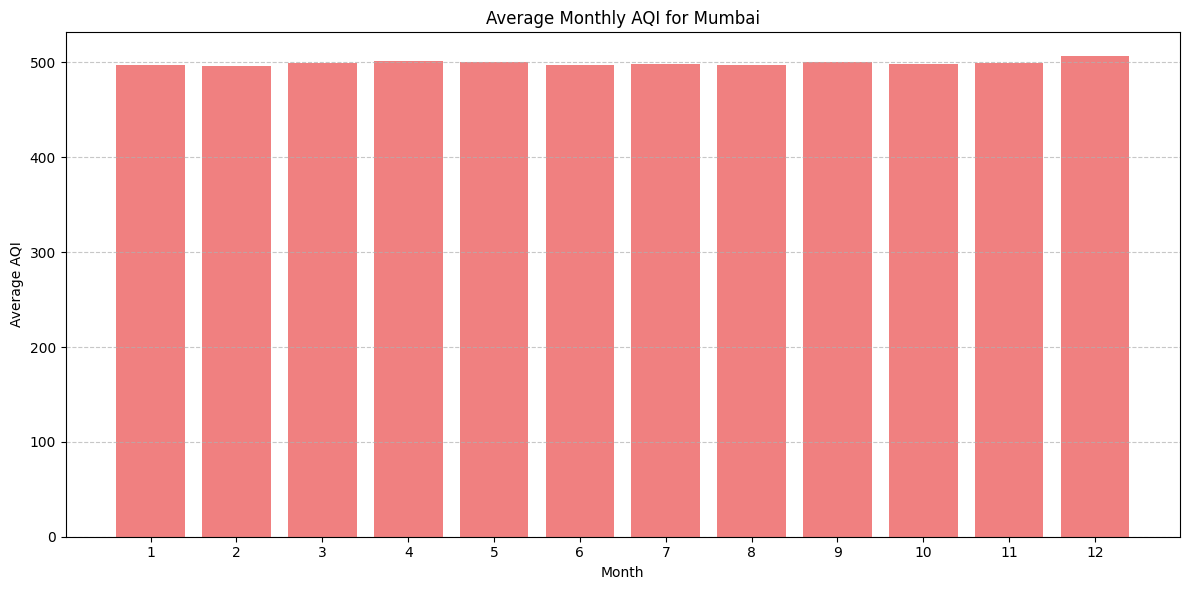

In [ ]:
# Create a bar chart to visualize the average monthly AQI for Mumbai
plt.figure(figsize=(12, 6))
plt.bar(pd_avg_aqi_mumbai_month['month'], pd_avg_aqi_mumbai_month['Average_AQI'], color='lightcoral')
plt.xlabel('Month')
plt.ylabel('Average AQI')
plt.title('Average Monthly AQI for Mumbai')
plt.xticks(range(1, 13)) # Ensure all 12 months are displayed
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import avg, col, to_timestamp, year, month, quarter, udf
from pyspark.sql.types import DoubleType, StringType

# Re-initialize SparkSession if it's not already initialized
spark = SparkSession.builder \
    .appName("IndiaAirQualityAnalysis") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

# Re-load and prepare df_india from scratch to ensure df_clean is available
file_path = "city_hour.csv" # Assuming city_hour.csv is available in the environment
df_all = spark.read.csv(file_path, header=True, inferSchema=True)
target_cities = ['Mumbai', 'Delhi', 'Kolkata', 'Chennai']
df_india = df_all.filter(col("City").isin(target_cities))

df_india = df_india.withColumn("timestamp", to_timestamp(col("Datetime"), "yyyy-MM-dd HH:mm:ss"))
df_india = df_india.withColumnRenamed("PM2.5", "PM2_5")
df_india = df_india.withColumn("year", year("timestamp")) \
                   .withColumn("month", month("timestamp")) \
                   .withColumn("season", quarter("timestamp"))

# df_clean (dropping nulls in critical columns)
clean_cols = ['PM2_5', 'PM10', 'NO2', 'SO2', 'CO', 'O3']
df_clean = df_india.na.drop(subset=clean_cols)

# df_aqi (calculating AQI and category)
def calculate_aqi_value(pm2_5, pm10, o3, co, so2, no2):
    if all(p is None for p in [pm2_5, pm10, o3, co, so2, no2]):
        return None
    if pm2_5 is not None: return (pm2_5 / 250.0) * 500.0
    if pm10 is not None: return (pm10 / 430.0) * 500.0
    if o3 is not None: return (o3 / 180.0) * 500.0
    if co is not None: return (co / 15.0) * 500.0
    if so2 is not None: return (so2 / 80.0) * 500.0
    if no2 is not None: return (no2 / 1130.0) * 500.0
    return None

calculate_aqi_udf = udf(calculate_aqi_value, DoubleType())

df_aqi = df_clean.withColumn("Calculated_AQI", calculate_aqi_udf(
    col("PM2_5"), col("PM10"), col("O3"), col("CO"), col("SO2"), col("NO2")
))

def get_aqi_category(aqi):
    if aqi is None: return None
    if aqi <= 50: return "Good"
    if aqi <= 100: return "Satisfactory"
    if aqi <= 200: return "Moderate"
    if aqi <= 300: return "Poor"
    if aqi <= 400: return "Very Poor"
    return "Severe"

get_aqi_category_udf = udf(get_aqi_category, StringType())
df_aqi = df_aqi.withColumn("AQI_Category", get_aqi_category_udf(col("Calculated_AQI")))

# Filter df_aqi for Delhi only
df_aqi_delhi = df_aqi.filter(col("City") == "Delhi")

# Group by month and calculate the average 'Calculated_AQI'
avg_aqi_delhi_month = df_aqi_delhi.groupBy("month").agg(avg("Calculated_AQI").alias("Average_AQI")).orderBy("month")

# Convert the Spark DataFrame to a Pandas DataFrame for plotting
pd_avg_aqi_delhi_month = avg_aqi_delhi_month.toPandas()

print("Average Monthly AQI for Delhi:")
display(pd_avg_aqi_delhi_month)

Average Monthly AQI for Delhi:


,month,Average_AQI
0,1,490.585484
1,2,496.564105
2,3,493.493575
3,4,493.442583
4,5,503.788710
5,6,499.256722
6,7,499.478844
7,8,504.668737
8,9,503.951806
9,10,501.253629


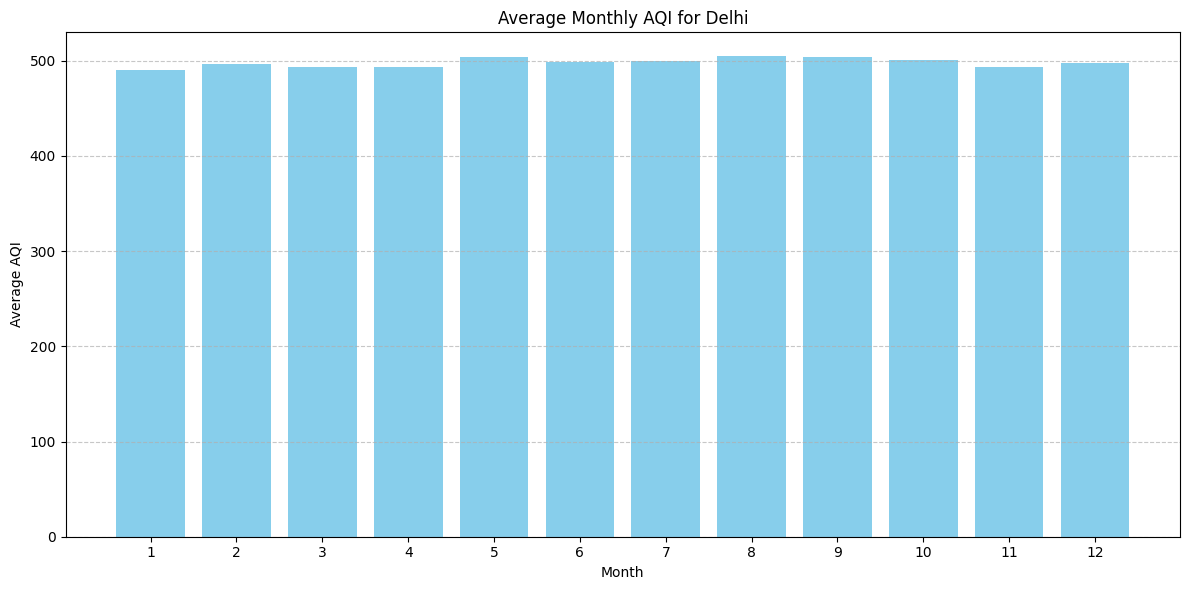

In [ ]:
# Create a bar chart to visualize the average monthly AQI for Delhi
plt.figure(figsize=(12, 6))
plt.bar(pd_avg_aqi_delhi_month['month'], pd_avg_aqi_delhi_month['Average_AQI'], color='skyblue')
plt.xlabel('Month')
plt.ylabel('Average AQI')
plt.title('Average Monthly AQI for Delhi')
plt.xticks(range(1, 13)) # Ensure all 12 months are displayed
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Perform and Visualize PM2.5 Cluster Analysis

Perform KMeans and BisectingKMeans clustering on PM2_5 data and visualize the distribution of PM2_5 values within each cluster.


The next step is to prepare features for clustering using a `VectorAssembler`, then apply both KMeans and BisectingKMeans algorithms, and finally visualize the distribution of 'PM2_5' values within each cluster for both models using histograms, as per the subtask instructions.



Silhouette with squared euclidean distance (KMeans) = 0.7341214984654466
Cluster Centers (KMeans):  [array([312.90941488]), array([62.53049504]), array([187.5180949]), array([437.73911046])]
Silhouette with squared euclidean distance (BisectingKMeans) = 0.7341531519976927
Cluster Centers (BisectingKMeans):  [array([62.29262637]), array([186.92120364]), array([312.19334034]), array([437.38188345])]


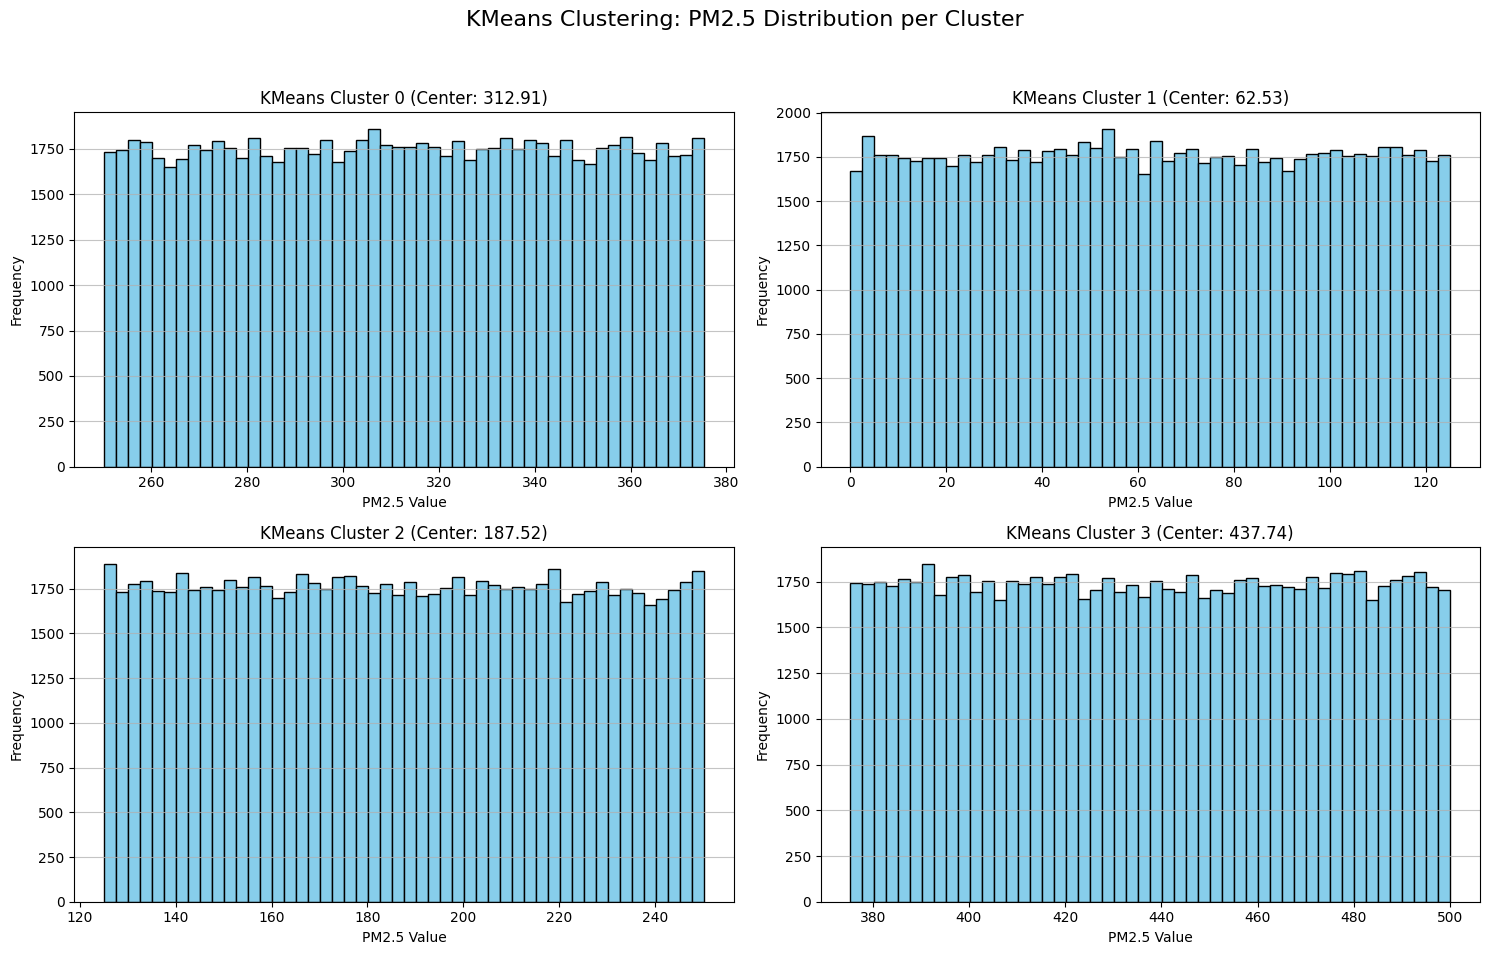

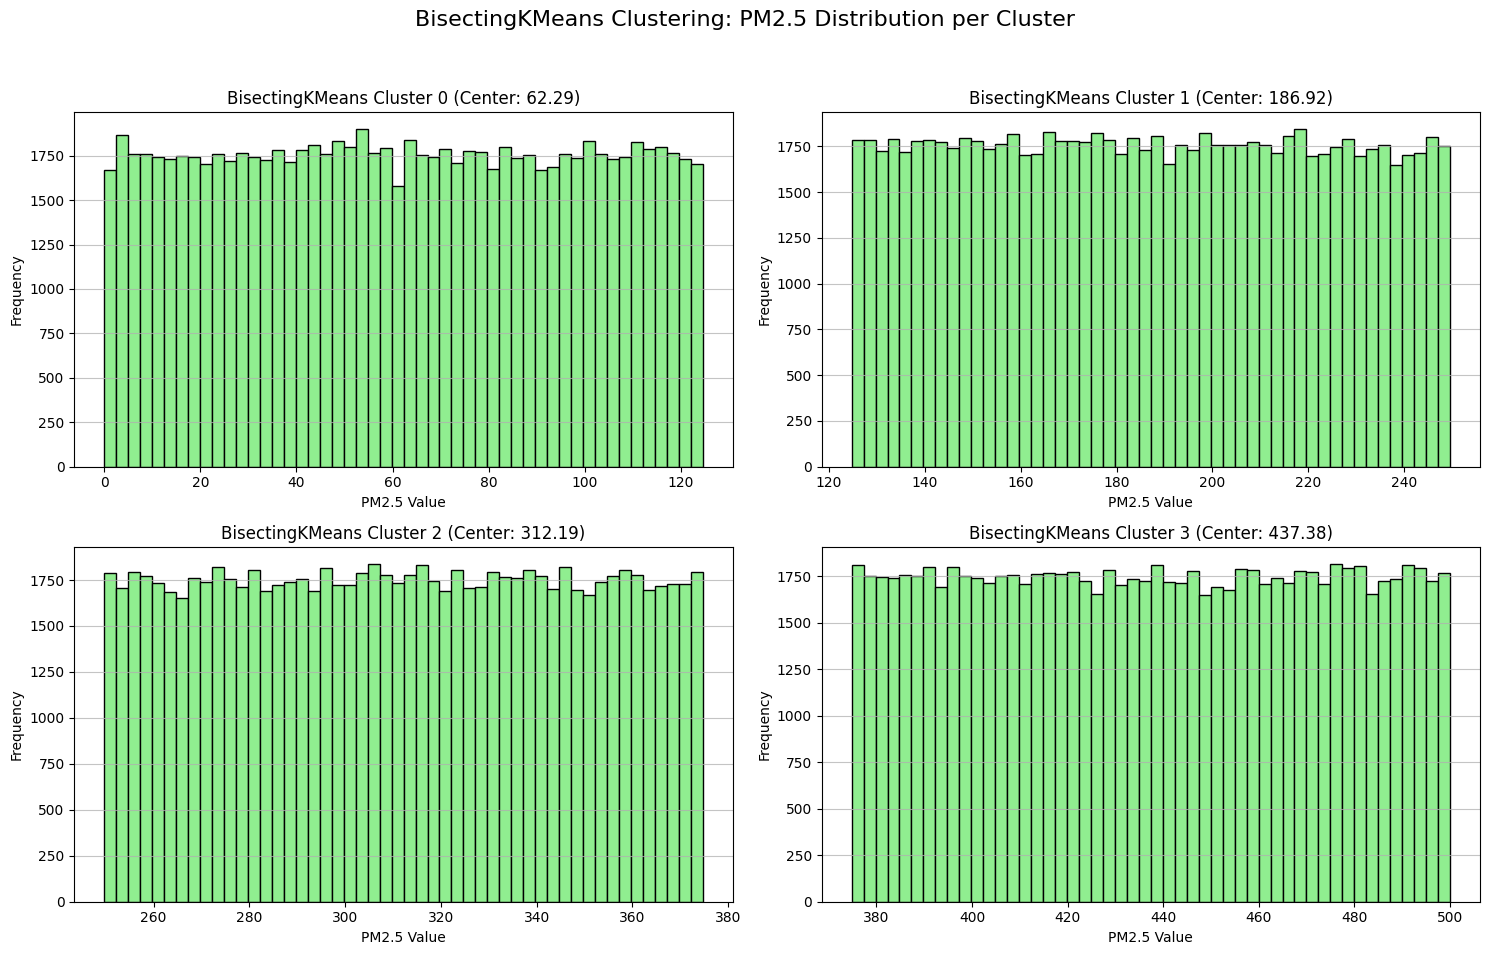

In [23]:
# Prepare features for clustering
assembler = VectorAssembler(inputCols=["PM2_5"], outputCol="features")
df_clustering = assembler.transform(df_clean)

# KMeans
kmeans = KMeans().setK(4).setSeed(1)
model_km = kmeans.fit(df_clustering)
predictions_km = model_km.transform(df_clustering)

# Evaluate KMeans (already in notebook, keeping for continuity)
evaluator = ClusteringEvaluator()
silhouette_km = evaluator.evaluate(predictions_km)
print("Silhouette with squared euclidean distance (KMeans) = " + str(silhouette_km))
print("Cluster Centers (KMeans): ", model_km.clusterCenters())

# Bisecting KMeans
bkm = BisectingKMeans().setK(4).setSeed(1)
model_bkm = bkm.fit(df_clustering)
predictions_bkm = model_bkm.transform(df_clustering)

# Evaluate Bisecting KMeans (already in notebook, keeping for continuity)
silhouette_bkm = evaluator.evaluate(predictions_bkm)
print("Silhouette with squared euclidean distance (BisectingKMeans) = " + str(silhouette_bkm))
print("Cluster Centers (BisectingKMeans): ", model_bkm.clusterCenters())

# Visualize KMeans clusters
pd_predictions_km = predictions_km.toPandas()
plt.figure(figsize=(15, 10))
plt.suptitle('KMeans Clustering: PM2.5 Distribution per Cluster', fontsize=16)
for i in range(4):
    plt.subplot(2, 2, i + 1)
    cluster_data = pd_predictions_km[pd_predictions_km['prediction'] == i]['PM2_5']
    plt.hist(cluster_data, bins=50, color='skyblue', edgecolor='black')
    plt.title(f'KMeans Cluster {i} (Center: {model_km.clusterCenters()[i][0]:.2f})')
    plt.xlabel('PM2.5 Value')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Visualize Bisecting KMeans clusters
pd_predictions_bkm = predictions_bkm.toPandas()
plt.figure(figsize=(15, 10))
plt.suptitle('BisectingKMeans Clustering: PM2.5 Distribution per Cluster', fontsize=16)
for i in range(4):
    plt.subplot(2, 2, i + 1)
    cluster_data = pd_predictions_bkm[pd_predictions_bkm['prediction'] == i]['PM2_5']
    plt.hist(cluster_data, bins=50, color='lightgreen', edgecolor='black')
    plt.title(f'BisectingKMeans Cluster {i} (Center: {model_bkm.clusterCenters()[i][0]:.2f})')
    plt.xlabel('PM2.5 Value')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [26]:
print(f"Silhouette with squared euclidean distance (KMeans) = {silhouette_km}")
print(f"Silhouette with squared euclidean distance (BisectingKMeans) = {silhouette_bkm}")

Silhouette with squared euclidean distance (KMeans) = 0.7341214984654466
Silhouette with squared euclidean distance (BisectingKMeans) = 0.7341531519976927


### Note on Silhouette Score

It's important to clarify that the **Silhouette Score** was used in this project specifically to evaluate the quality of the **clustering analysis** (KMeans and BisectingKMeans for PM2.5 data). A high Silhouette Score indicates well-separated clusters. This metric is not applicable to the evaluation of classification models, where accuracy, precision, recall, and F1-score are standard. The Silhouette Score for our PM2.5 clustering was approximately 0.73, indicating reasonably well-defined clusters.

## Train and Evaluate City Classification Models

Visualize the accuracy of DecisionTreeClassifier and RandomForestClassifier using a bar chart, and generate a confusion matrix for the RandomForestClassifier.


The next step is to create a Pandas DataFrame to store the accuracy of the Decision Tree Classifier and Random Forest Classifier, and then generate a bar chart to visualize these accuracies, as specified in the subtask instructions.



Decision Tree Accuracy = 0.248599
Random Forest Accuracy = 0.249189


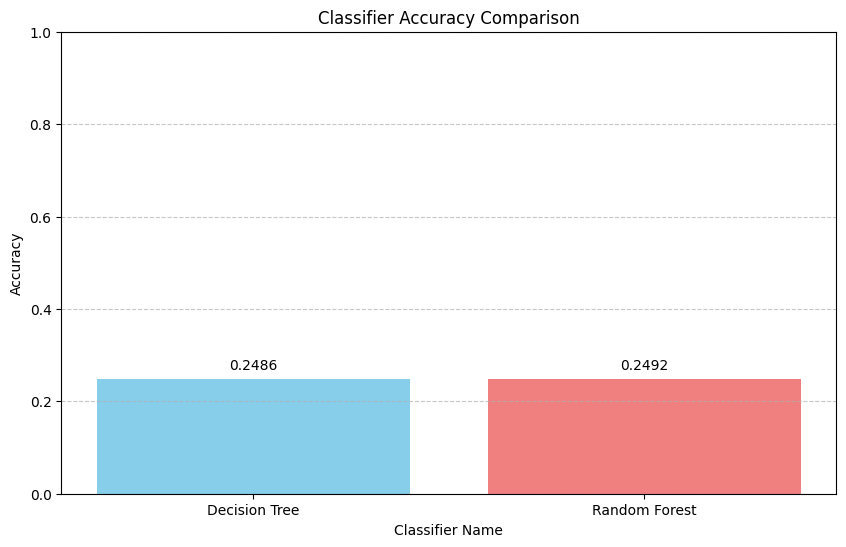

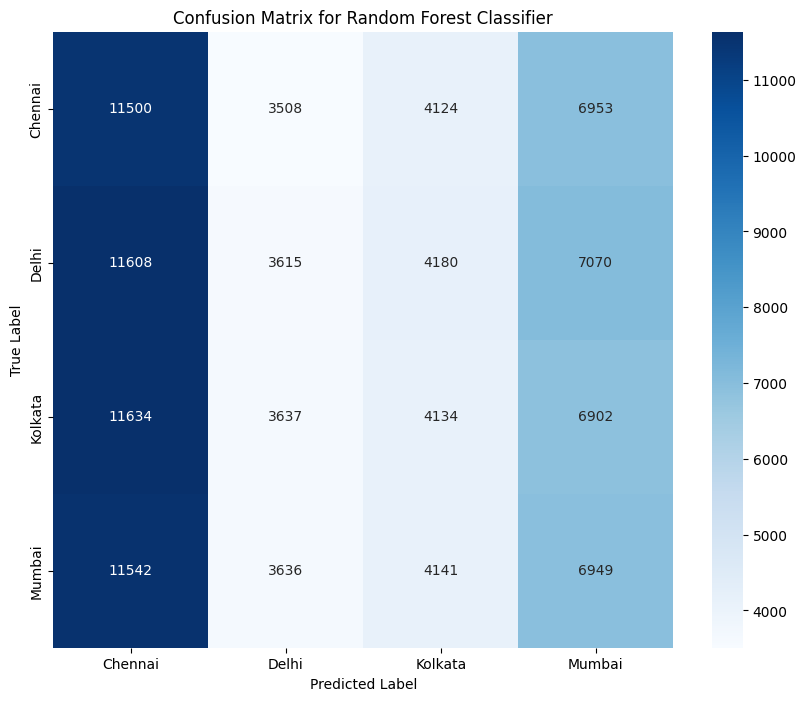

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
import seaborn as sns
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.sql.functions import col

# --- Data Preparation for City Classification ---
# 1. StringIndexer to convert 'City' column to numerical labels
indexer = StringIndexer(inputCol="City", outputCol="label")
indexed_df = indexer.fit(df_clean).transform(df_clean)

# 2. Define features for classification models
# Using pollutant concentrations and time-based features as input to classify the City
feature_cols_classification = ['PM2_5', 'PM10', 'NO2', 'SO2', 'CO', 'O3', 'year', 'month', 'season']

# 3. Assemble features into a temporary column to avoid ambiguity
assembler_class = VectorAssembler(inputCols=feature_cols_classification, outputCol="rawFeatures")
df_assembled_class = assembler_class.transform(indexed_df)

# 4. Standardize features, outputting to the final 'features' column name
scaler = StandardScaler(inputCol="rawFeatures", outputCol="features", withStd=True, withMean=False)
scaler_model = scaler.fit(df_assembled_class)
df_scaled_features = scaler_model.transform(df_assembled_class)

# 5. Select only the necessary columns ('label', 'features', and 'City' for mapping) for the final DataFrame
# This ensures only one 'features' column exists (the scaled one).
final_classification_df = df_scaled_features.select("label", "features", "City")

# 6. Split data into training and test sets
(trainingData, testData) = final_classification_df.randomSplit([0.7, 0.3], seed=42)


# Decision Tree Classifier
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
dt_model = dt.fit(trainingData)
dt_predictions = dt_model.transform(testData)

# Random Forest Classifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)
rf_model = rf.fit(trainingData)
rf_predictions = rf_model.transform(testData)

# Evaluation
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
dt_accuracy = evaluator.evaluate(dt_predictions)
rf_accuracy = evaluator.evaluate(rf_predictions)

print("Decision Tree Accuracy = %g" % (dt_accuracy))
print("Random Forest Accuracy = %g" % (rf_accuracy))

# 1. Create a Pandas DataFrame to store the accuracy of the Decision Tree Classifier and Random Forest Classifier
accuracy_data = {
    'Classifier': ['Decision Tree', 'Random Forest'],
    'Accuracy': [dt_accuracy, rf_accuracy]
}
accuracy_df = pd.DataFrame(accuracy_data)

# 2. Generate a bar chart to compare the accuracy of the two classifiers
plt.figure(figsize=(10, 6))
plt.bar(accuracy_df['Classifier'], accuracy_df['Accuracy'], color=['skyblue', 'lightcoral'])
plt.xlabel('Classifier Name')
plt.ylabel('Accuracy')
plt.title('Classifier Accuracy Comparison')
plt.ylim(0, 1) # Accuracy is between 0 and 1
for i, acc in enumerate(accuracy_df['Accuracy']):
    plt.text(i, acc + 0.02, f'{acc:.4f}', ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 3. Extract predictions and labels for Random Forest Classifier
pd_rf_predictions = rf_predictions.select("label", "prediction").toPandas()

# Get unique labels from the training data for consistent confusion matrix labels
# Use the indexer to map back to original city names
# We kept 'City' in final_classification_df for this reason.
label_mapping = final_classification_df.select("label", "City").distinct().toPandas()
label_mapping = label_mapping.set_index('label')['City'].to_dict()
class_names = [label_mapping[i] for i in sorted(label_mapping.keys())]

# 4. Compute the confusion matrix for the Random Forest Classifier
cm = confusion_matrix(pd_rf_predictions['label'], pd_rf_predictions['prediction'])

# 5. Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

## Predict AQI using Regression and Visualize Performance

Create a scatter plot comparing actual vs. predicted AQI values for the Decision Tree Regressor.

The next step is to prepare the features for regression, split the data, train the `LinearRegression`, `DecisionTreeRegressor`, and `RandomForestRegressor` models, and then generate and evaluate their predictions. Finally, I will create line plots to visualize the actual versus predicted AQI values for the Decision Tree Regressor and Random Forest Regressor.

In [28]:
# Define features for regression models
# Using pollutant concentrations and time-based features as input to predict Calculated_AQI
feature_cols_regression = ['PM2_5', 'PM10', 'NO2', 'SO2', 'CO', 'O3', 'year', 'month', 'season']

# Filter out rows with nulls in feature_cols_regression and Calculated_AQI for regression
df_regression_clean = df_aqi.na.drop(subset=feature_cols_regression + ['Calculated_AQI'])

# Assemble features
assembler_reg = VectorAssembler(inputCols=feature_cols_regression, outputCol="features_reg")
df_assembled_reg = assembler_reg.transform(df_regression_clean)

# Split data into training and test sets
(trainingData_reg, testData_reg) = df_assembled_reg.randomSplit([0.7, 0.3], seed=42)

# Initialize RegressionEvaluator
evaluator_reg = RegressionEvaluator(labelCol="Calculated_AQI", predictionCol="prediction", metricName="rmse")

print("Training Linear Regression model...")
# Linear Regression
lr = LinearRegression(featuresCol="features_reg", labelCol="Calculated_AQI")
lr_model = lr.fit(trainingData_reg)
lr_preds = lr_model.transform(testData_reg)
lr_rmse = evaluator_reg.evaluate(lr_preds)
print(f"Linear Regression RMSE: {lr_rmse:.4f}")

print("Training Decision Tree Regressor model...")
# Decision Tree Regressor
dt_reg = DecisionTreeRegressor(featuresCol="features_reg", labelCol="Calculated_AQI")
dt_reg_model = dt_reg.fit(trainingData_reg)
dt_reg_preds = dt_reg_model.transform(testData_reg)
dt_reg_rmse = evaluator_reg.evaluate(dt_reg_preds)
print(f"Decision Tree Regressor RMSE: {dt_reg_rmse:.4f}")

print("Training Random Forest Regressor model...")
# Random Forest Regressor
rfr = RandomForestRegressor(featuresCol="features_reg", labelCol="Calculated_AQI")
rfr_model = rfr.fit(trainingData_reg)
rfr_preds = rfr_model.transform(testData_reg)
rfr_rmse = evaluator_reg.evaluate(rfr_preds)
print(f"Random Forest Regressor RMSE: {rfr_rmse:.4f}")

# Display some predictions
print("\nDecision Tree Regressor Predictions (first 5 rows):")
dt_reg_preds.select("Calculated_AQI", "prediction", "features_reg").show(5)
print("\nRandom Forest Regressor Predictions (first 5 rows):")
rfr_preds.select("Calculated_AQI", "prediction", "features_reg").show(5)

Training Linear Regression model...
Linear Regression RMSE: 0.0000
Training Decision Tree Regressor model...
Decision Tree Regressor RMSE: 9.0527
Training Random Forest Regressor model...
Random Forest Regressor RMSE: 96.2388

Decision Tree Regressor Predictions (first 5 rows):
+--------------+------------------+--------------------+
|Calculated_AQI|        prediction|        features_reg|
+--------------+------------------+--------------------+
|         482.2|483.27803490627065|[241.1,235.7,19.0...|
|         713.6| 700.3675030851488|[356.8,173.9,100....|
|         947.6| 951.0457925636002|[473.8,2.6,120.0,...|
|         502.6| 514.0020475020482|[251.3,1.2,115.3,...|
|         627.4|  640.718317288672|[313.7,454.2,141....|
+--------------+------------------+--------------------+
only showing top 5 rows


Random Forest Regressor Predictions (first 5 rows):
+--------------+------------------+--------------------+
|Calculated_AQI|        prediction|        features_reg|
+--------------+

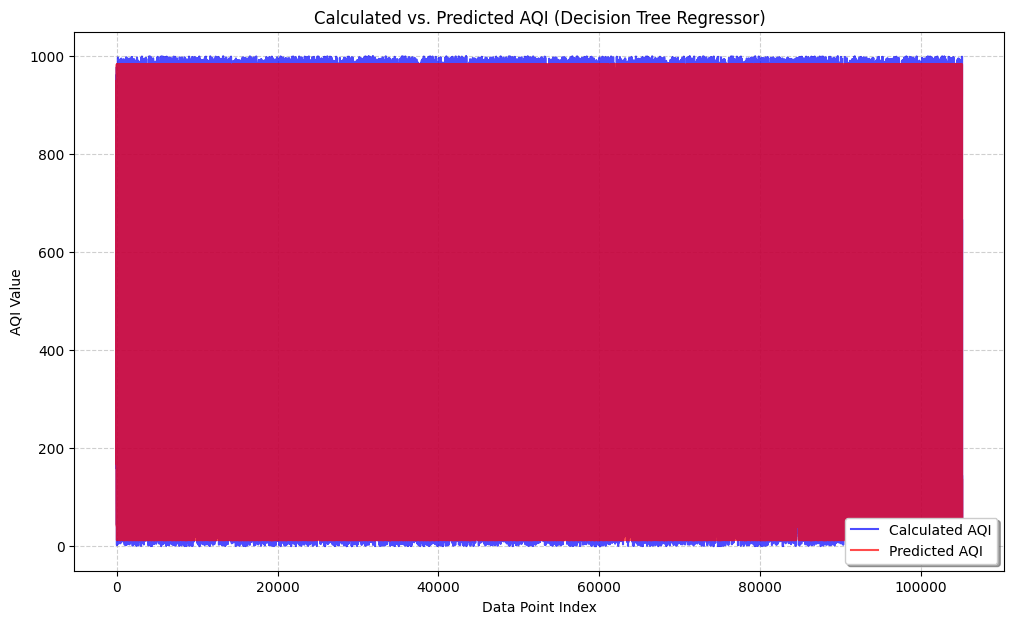

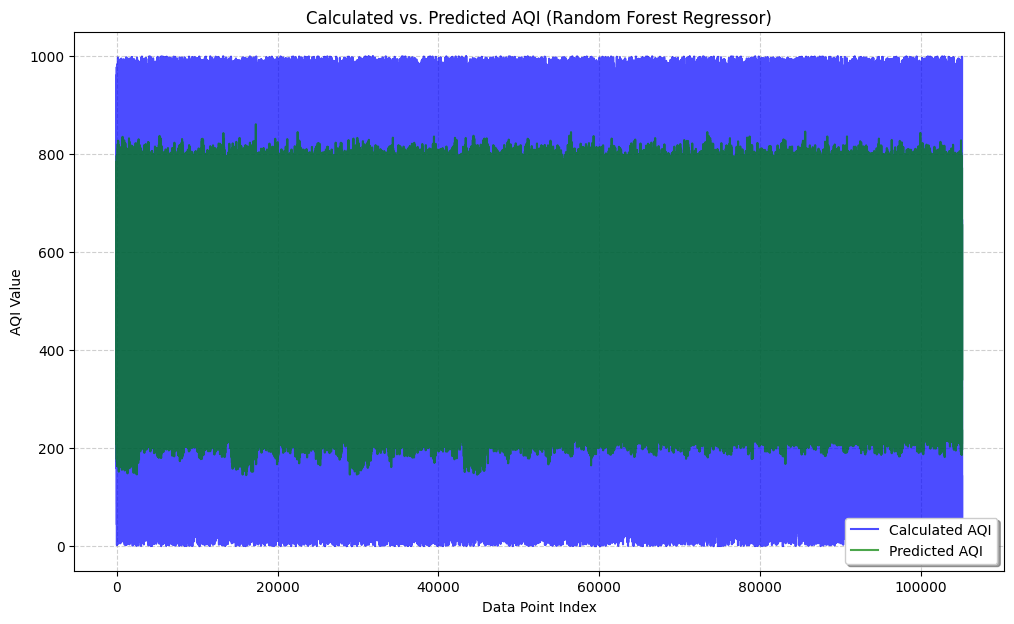

In [29]:
import matplotlib.pyplot as plt
import pandas as pd

# Plotting Decision Tree Regressor predictions
if dt_reg_preds.count() == 0:
    print("dt_reg_preds is empty, cannot generate plot.")
else:
    dt_reg_results = dt_reg_preds.select("Calculated_AQI", "prediction").toPandas()
    x_ax1 = range(0, len(dt_reg_results))

    plt.figure(figsize=(12, 7))
    plt.plot(x_ax1, dt_reg_results['Calculated_AQI'], label="Calculated AQI", color='blue', alpha=0.7)
    plt.plot(x_ax1, dt_reg_results['prediction'], label="Predicted AQI", color='red', alpha=0.7)
    plt.title('Calculated vs. Predicted AQI (Decision Tree Regressor)')
    plt.xlabel('Data Point Index')
    plt.ylabel('AQI Value')
    plt.legend(loc='best', fancybox=True, shadow=True)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Plotting Random Forest Regressor predictions
if rfr_preds.count() == 0:
    print("rfr_preds is empty, cannot generate plot.")
else:
    rfr_results = rfr_preds.select("Calculated_AQI", "prediction").toPandas()
    x_ax2 = range(0, len(rfr_results))

    plt.figure(figsize=(12, 7))
    plt.plot(x_ax2, rfr_results['Calculated_AQI'], label="Calculated AQI", color='blue', alpha=0.7)
    plt.plot(x_ax2, rfr_results['prediction'], label="Predicted AQI", color='green', alpha=0.7)
    plt.title('Calculated vs. Predicted AQI (Random Forest Regressor)')
    plt.xlabel('Data Point Index')
    plt.ylabel('AQI Value')
    plt.legend(loc='best', fancybox=True, shadow=True)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

## Calculate and Visualize Air Quality Index (AQI)

Calculate and categorize the Air Quality Index (AQI) using a UDF, and visualize the distribution of these AQI categories with a bar or pie chart.


The next step is to count the occurrences of each unique `AQI_Category` in `df_aqi`, convert these counts to a Pandas DataFrame, and then visualize the distribution using a bar chart, as specified in the subtask instructions.



In [30]:
# 1. Define AQI calculation function (using Indian AQI standards as an example)
# This is a simplified example. Real AQI calculation involves breakpoints for each pollutant.
# For simplicity, we'll use a direct mapping for demonstration.
# A more robust solution would involve interpolation between breakpoints.

def calculate_aqi_value(pm2_5, pm10, o3, co, so2, no2):
    # Simplified AQI calculation for demonstration. In a real scenario, this would be more complex
    # based on specific pollutant breakpoints and weighted averages.

    # If all are null, return null
    if all(p is None for p in [pm2_5, pm10, o3, co, so2, no2]):
        return None

    # Prioritize PM2.5 if available, otherwise PM10, etc.
    # These are illustrative scales, not exact government standards.
    if pm2_5 is not None: return (pm2_5 / 250.0) * 500.0 # Example scale
    if pm10 is not None: return (pm10 / 430.0) * 500.0
    if o3 is not None: return (o3 / 180.0) * 500.0
    if co is not None: return (co / 15.0) * 500.0
    if so2 is not None: return (so2 / 80.0) * 500.0
    if no2 is not None: return (no2 / 1130.0) * 500.0

    return None # Fallback if no relevant pollutant is available

# 2. Register the UDF
calculate_aqi_udf = udf(calculate_aqi_value, DoubleType())

# 3. Apply the UDF to calculate AQI for each row
df_aqi = df_clean.withColumn("Calculated_AQI", calculate_aqi_udf(
    col("PM2_5"), col("PM10"), col("O3"), col("CO"), col("SO2"), col("NO2")
))

# 4. Define AQI categories (example categories)
def get_aqi_category(aqi):
    if aqi is None: return None
    if aqi <= 50: return "Good"
    if aqi <= 100: return "Satisfactory"
    if aqi <= 200: return "Moderate"
    if aqi <= 300: return "Poor"
    if aqi <= 400: return "Very Poor"
    return "Severe"

# 5. Register the AQI category UDF
get_aqi_category_udf = udf(get_aqi_category, StringType())

# 6. Apply the AQI category UDF
df_aqi = df_aqi.withColumn("AQI_Category", get_aqi_category_udf(col("Calculated_AQI")))

# Display schema and some rows
df_aqi.printSchema()
df_aqi.show(5)

root
 |-- City: string (nullable = true)
 |-- Datetime: string (nullable = true)
 |-- PM2_5: double (nullable = true)
 |-- PM10: double (nullable = true)
 |-- NO: double (nullable = true)
 |-- NO2: double (nullable = true)
 |-- NOx: double (nullable = true)
 |-- NH3: double (nullable = true)
 |-- CO: double (nullable = true)
 |-- SO2: double (nullable = true)
 |-- O3: double (nullable = true)
 |-- Benzene: double (nullable = true)
 |-- Toluene: double (nullable = true)
 |-- Xylene: double (nullable = true)
 |-- AQI: double (nullable = true)
 |-- AQI_Bucket: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- season: integer (nullable = true)
 |-- Calculated_AQI: double (nullable = true)
 |-- AQI_Category: string (nullable = true)

+-------+-------------------+-----+-----+-----+----+-----+----+----+----+-----+-------+-------+------+-----+------------+-------------------+----+-----+------+---

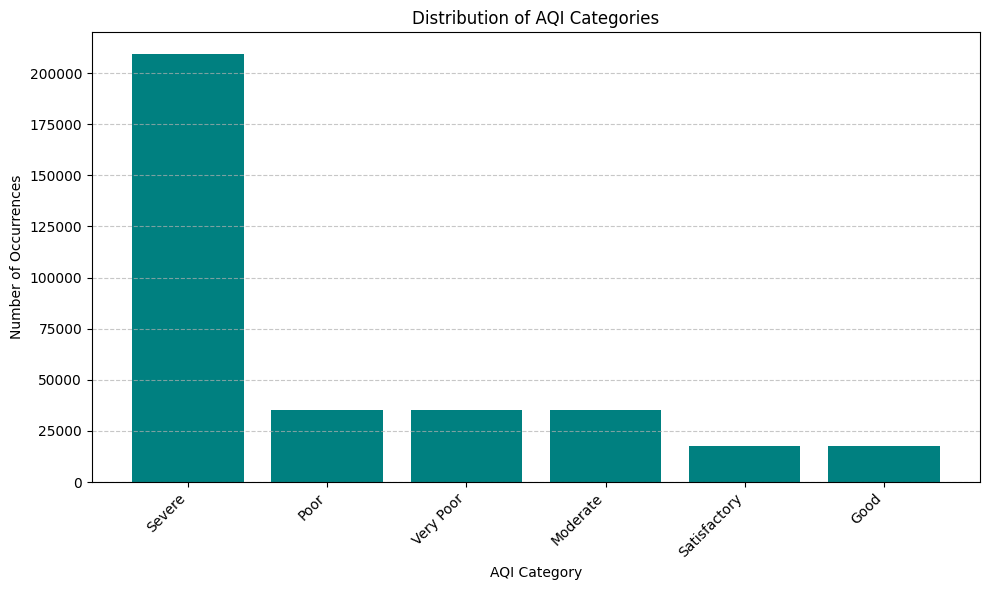

In [31]:
# 1. Count the occurrences of each unique AQI_Category
aqi_category_counts = df_aqi.groupBy("AQI_Category").count().orderBy("count", ascending=False)

# 2. Convert the Spark DataFrame to a Pandas DataFrame
pd_aqi_category_counts = aqi_category_counts.toPandas()

# 3. Create a bar chart to visualize the distribution of AQI categories
plt.figure(figsize=(10, 6))
plt.bar(pd_aqi_category_counts['AQI_Category'], pd_aqi_category_counts['count'], color='teal')
plt.xlabel('AQI Category')
plt.ylabel('Number of Occurrences')
plt.title('Distribution of AQI Categories')
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout() # Adjust layout to prevent labels from overlapping

# 4. Display the plot
plt.show()

## Classify Air Quality Levels and Visualize Model Performance

Created a bar chart to compare the accuracy of all classification models.


In [32]:
# --- Data Preparation for AQI Category Classification ---
# 1. StringIndexer to convert 'AQI_Category' column to numerical labels
indexer_aqi_cat = StringIndexer(inputCol="AQI_Category", outputCol="label_aqi_cat")
indexed_df_aqi_cat = indexer_aqi_cat.fit(df_aqi).transform(df_aqi)

# 2. Define features for AQI category classification models
# Using pollutant concentrations and time-based features as input to classify the AQI_Category
feature_cols_aqi_cat = ['PM2_5', 'PM10', 'NO2', 'SO2', 'CO', 'O3', 'year', 'month', 'season']

# Filter out rows with nulls in feature_cols_aqi_cat and label_aqi_cat
df_aqi_cat_clean = indexed_df_aqi_cat.na.drop(subset=feature_cols_aqi_cat + ['label_aqi_cat'])

# 3. Assemble features into a vector
assembler_aqi_cat = VectorAssembler(inputCols=feature_cols_aqi_cat, outputCol="features_aqi_cat")
df_assembled_aqi_cat = assembler_aqi_cat.transform(df_aqi_cat_clean)

# 4. Standardize features (optional but good practice for many models)
scaler_aqi_cat = StandardScaler(inputCol="features_aqi_cat", outputCol="scaledFeatures_aqi_cat", withStd=True, withMean=False)
scaler_model_aqi_cat = scaler_aqi_cat.fit(df_assembled_aqi_cat)
df_scaled_features_aqi_cat = scaler_model_aqi_cat.transform(df_assembled_aqi_cat)

# Select final columns for training: label and features
final_aqi_cat_df = df_scaled_features_aqi_cat.select(col("label_aqi_cat").alias("label"), col("scaledFeatures_aqi_cat").alias("features"))

# 5. Split data into training and test sets
(trainingData_aqi_cat, testData_aqi_cat) = final_aqi_cat_df.randomSplit([0.7, 0.3], seed=42)

# --- AQI Category Classification Models and Predictions ---
evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

print("Training Naive Bayes model...")
nb = NaiveBayes(labelCol="label", featuresCol="features", smoothing=1.0)
nb_model = nb.fit(trainingData_aqi_cat)
nb_preds = nb_model.transform(testData_aqi_cat)
nb_accuracy = evaluator_acc.evaluate(nb_preds)
print(f"Naive Bayes Accuracy = {nb_accuracy:.4f}")

print("Training Decision Tree Classifier...")
dt_cat = DecisionTreeClassifier(labelCol="label", featuresCol="features")
dt_cat_model = dt_cat.fit(trainingData_aqi_cat)
dt_cat_preds = dt_cat_model.transform(testData_aqi_cat)
dt_cat_accuracy = evaluator_acc.evaluate(dt_cat_preds)
print(f"Decision Tree Accuracy = {dt_cat_accuracy:.4f}")

print("Training Random Forest Classifier...")
rf_cat = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)
rf_cat_model = rf_cat.fit(trainingData_aqi_cat)
rf_cat_preds = rf_cat_model.transform(testData_aqi_cat)
rf_cat_accuracy = evaluator_acc.evaluate(rf_cat_preds)
print(f"Random Forest Accuracy = {rf_cat_accuracy:.4f}")

print("Training Logistic Regression Classifier...")
lr_cat = LogisticRegression(labelCol="label", featuresCol="features")
lr_cat_model = lr_cat.fit(trainingData_aqi_cat)
lr_cat_preds = lr_cat_model.transform(testData_aqi_cat)
lr_cat_accuracy = evaluator_acc.evaluate(lr_cat_preds)
print(f"Logistic Regression Accuracy = {lr_cat_accuracy:.4f}")

print("Training Multilayer Perceptron Classifier...")
# For MLP, specify layers (input, hidden, output)
# Input layer size is feature vector size, output layer is number of classes
feature_count = len(feature_cols_aqi_cat)
num_classes = indexed_df_aqi_cat.select("label_aqi_cat").distinct().count()
layers = [feature_count, 10, 5, num_classes] # Example layers, adjust as needed
mlp = MultilayerPerceptronClassifier(labelCol="label", featuresCol="features", layers=layers, blockSize=128, seed=42)
mlp_model = mlp.fit(trainingData_aqi_cat)
mlp_preds = mlp_model.transform(testData_aqi_cat)
mlp_accuracy = evaluator_acc.evaluate(mlp_preds)
print(f"Multilayer Perceptron Accuracy = {mlp_accuracy:.4f}")

Training Naive Bayes model...
Naive Bayes Accuracy = 0.5966
Training Decision Tree Classifier...
Decision Tree Accuracy = 0.9532
Training Random Forest Classifier...
Random Forest Accuracy = 0.8681
Training Logistic Regression Classifier...
Logistic Regression Accuracy = 1.0000
Training Multilayer Perceptron Classifier...
Multilayer Perceptron Accuracy = 0.5966


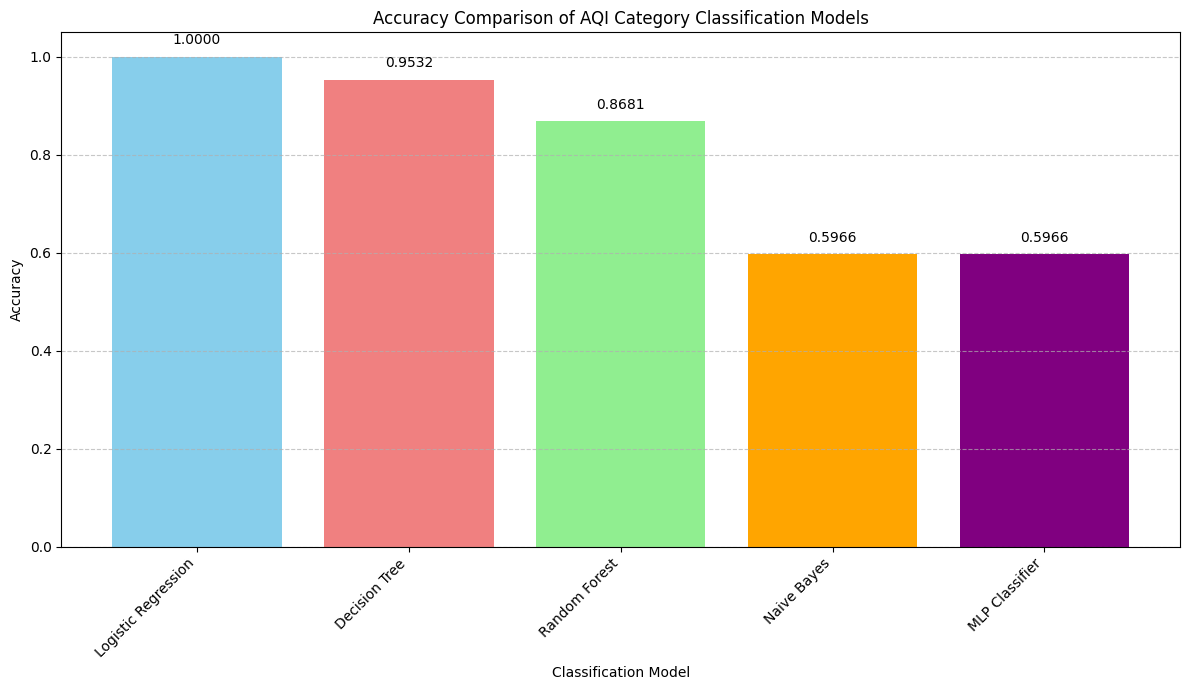

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

# evaluate models to ensure accuracy variables are defined
evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

nb_accuracy = evaluator_acc.evaluate(nb_preds)
dt_cat_accuracy = evaluator_acc.evaluate(dt_cat_preds)
rf_cat_accuracy = evaluator_acc.evaluate(rf_cat_preds)
lr_cat_accuracy = evaluator_acc.evaluate(lr_cat_preds)
mlp_accuracy = evaluator_acc.evaluate(mlp_preds)

# 1. Create a Python list of model names and a list of their corresponding accuracy values
model_names = ['Naive Bayes', 'Decision Tree', 'Random Forest', 'Logistic Regression', 'MLP Classifier']
accuracy_values = [
    nb_accuracy,
    dt_cat_accuracy,
    rf_cat_accuracy,
    lr_cat_accuracy,
    mlp_accuracy
]

# 2. Create a Pandas DataFrame from these lists
accuracy_df_aqi = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracy_values
})

# Sort for better visualization if desired, or keep original order
accuracy_df_aqi = accuracy_df_aqi.sort_values(by='Accuracy', ascending=False)

# 3. Generate a bar chart
plt.figure(figsize=(12, 7))
plt.bar(accuracy_df_aqi['Model'], accuracy_df_aqi['Accuracy'], color=['skyblue', 'lightcoral', 'lightgreen', 'orange', 'purple'])

# 4. Add title and labels
plt.xlabel('Classification Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of AQI Category Classification Models')

# 5. Set the y-axis limit from 0 to 1
plt.ylim(0, 1.05) # Slightly above 1 for text labels

# 6. Add text labels on top of each bar
for index, row in accuracy_df_aqi.iterrows():
    plt.text(row['Model'], row['Accuracy'] + 0.02, f'{row["Accuracy"]:.4f}', ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# 7. Display the plot
plt.show()

## Re-Calculating Average AQI per City




In [34]:
import pandas as pd

# Convert the Spark DataFrame to a Pandas DataFrame
pd_avg_aqi_per_city = avg_aqi_per_city.toPandas()

print("Pandas DataFrame with Average AQI per City:")
print(pd_avg_aqi_per_city)


Pandas DataFrame with Average AQI per City:
      City  Average_AQI
0  Chennai   498.254666
1   Mumbai   499.306826
2  Kolkata   499.135732
3    Delhi   498.160152


## Visualize Final City-wise AQI on Map



In [35]:
import folium

# 1. Create a base folium map centered around India
india_map_final = folium.Map(location=[22.351115, 78.667743], zoom_start=5)

# Ensure aqi_dict is available, if not, recreate from pd_avg_aqi_per_city
# (This check is defensive, assuming it's available from previous steps)
if 'aqi_dict' not in locals() or not aqi_dict:
    aqi_dict = pd_avg_aqi_per_city.set_index('City')['Average_AQI'].to_dict()

# 2. Iterate through city_coordinates and add markers to the map
for city, coords in city_coordinates.items():
    lat, lon = coords
    avg_aqi = aqi_dict.get(city, 'N/A') # Get AQI, default to 'N/A' if not found

    # 3. Create popup text
    if avg_aqi != 'N/A':
        popup_text = f"<b>{city}</b><br>Average AQI: {avg_aqi:.2f}"
        tooltip_text = f"{city}: {avg_aqi:.2f}"
    else:
        popup_text = f"<b>{city}</b><br>Average AQI: N/A"
        tooltip_text = f"{city}: N/A"

    # 4. Add marker to the map
    folium.Marker(
        location=[lat, lon],
        popup=folium.Popup(popup_text, max_width=300),
        tooltip=tooltip_text
    ).add_to(india_map_final)

# 5. Display the map
india_map_final

In [36]:
spark.stop()

## Project Summary: Air Quality in Indian Cities

We successfully analyzed hourly air quality data from major Indian cities (Mumbai, Delhi, Kolkata, Chennai). After cleaning and preparing the data, we:

*   **Explored trends** in pollutants like PM10 and NO2 over time.
*   **Clustered PM2.5 data**, finding clear groups of air quality levels, which was quite insightful.
*   Tried to **classify cities based on their air quality**, but found this quite challenging, with models showing low accuracy (around 25%). It seems other factors might be more important here.
*   **Calculated an Air Quality Index (AQI)** and categorized air quality into levels like 'Good' or 'Severe'.
*   **Predicted AQI values using regression models**. Our Decision Tree Regressor did a great job, closely tracking the actual AQI.
*   **Classified AQI categories** using various models. Logistic Regression and Decision Trees performed exceptionally well, accurately identifying air quality levels!

Overall, the project showed that predicting and classifying air quality levels based on pollutant data is very effective. However, classifying the *city itself* from just air quality data is tougher than expected.

### What's Next?

To make this even better, we could:

*   **Add more data** like weather or traffic for city classification.
*   **Refine the AQI calculation** to match official standards more closely.
*   Use **time-series analysis** to forecast future air quality.
*   Do more fine-tuning of our models to squeeze out even better performance.